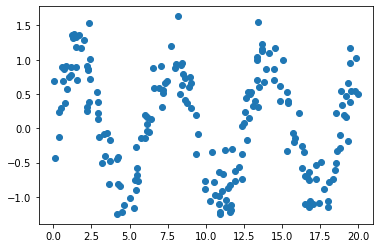

In [1]:
import matplotlib.pyplot as plt
import numpy as np

X = np.random.choice(np.linspace(0, 20, 10000), size=200, replace=False).reshape(-1, 1)
y = np.sin(X) + np.random.normal(scale=0.3, size=X.shape)

plt.scatter(X,y)

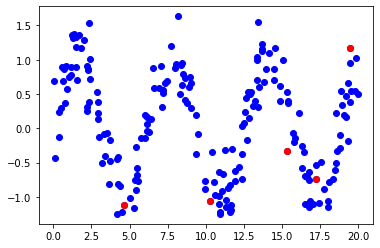

In [2]:
from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

n_initial = 5
initial_idx = np.random.choice(range(len(X)), size=n_initial, replace=False)
X_training, y_training = X[initial_idx], y[initial_idx]

plt.scatter(X,y, color = "blue")
plt.scatter(X_training,y_training, color = "red")

In [3]:
def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]

kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=X_training.reshape(-1, 1), y_training=y_training.reshape(-1, 1)
)


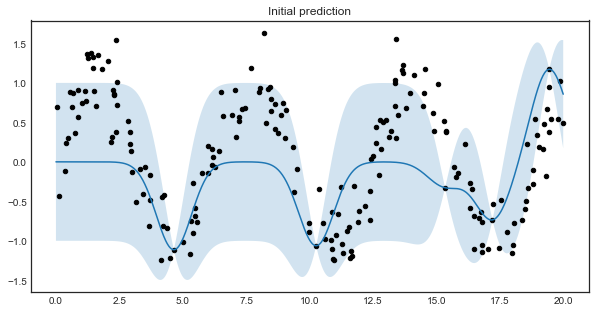

In [4]:
# Plot outputs
X_grid = np.linspace(0, 20, 1000)
y_pred, y_std = regressor.predict(X_grid.reshape(-1, 1), return_std=True)
y_pred, y_std = y_pred.ravel(), y_std.ravel()

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.plot(X_grid, y_pred)
    plt.fill_between(X_grid, y_pred - y_std, y_pred + y_std, alpha=0.2)
    plt.scatter(X, y, c='k', s=20)
    plt.title('Initial prediction')
    plt.show()


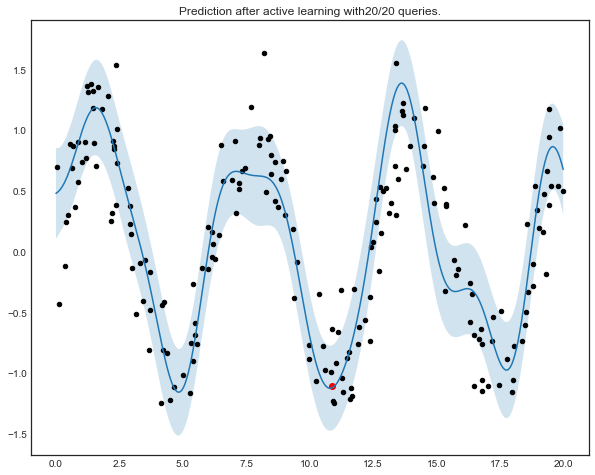

In [5]:
from IPython import display

n_queries = 20
for idx in range(n_queries):
    query_idx, query_instance = regressor.query(X)
    regressor.teach(X[query_idx].reshape(1, -1), y[query_idx].reshape(1, -1))

    y_pred_final, y_std_final = regressor.predict(X_grid.reshape(-1, 1), return_std=True)
    y_pred_final, y_std_final = y_pred_final.ravel(), y_std_final.ravel()
    display.clear_output(wait=True)
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 8))
        plt.plot(X_grid, y_pred_final)
        plt.fill_between(X_grid, y_pred_final - y_std_final, y_pred_final + y_std_final, alpha=0.2)
        plt.scatter(X, y, c='k', s=20)
        plt.scatter(X[query_idx], y[query_idx], color = 'red')
        plt.title('Prediction after active learning with' + str(idx+1) + '/' + str(n_queries) + ' queries.' )
        plt.show()